# Mohamaco – Model & Analysis Generator

**Goal:** Build a consolidated dataset across all weeks (versions), compute **indicators** and **real staff costs**, export `model_data.json`, and show quick sanity plots.

**Outputs**
- `model_data.json` — one record per (version, product) with indicators
- Quick preview plots for volume & revenue (no decisions here)

**Data inputs**  
`data/amounts/amounts_v.json`, `data/prices/prices_v.json`,  
`data/transactions/transactions_v.json`, `data/supplier_prices.json`,  
`data/schedules/schedules_v.json`, `data/workers/workers.jsonl`.

**Role of GPT (GPT-5):** data pipelining, robust parsing, indicators, staff-cost logic, concise visuals/documentation.

In [1]:
# === Load & Merge ============================================================
import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("ggplot")

DATA_DIR = Path("data")
AMOUNTS_DIR = DATA_DIR/"amounts"
PRICES_DIR = DATA_DIR/"prices"
TRANSACTIONS_DIR = DATA_DIR/"transactions"
SUPPLIER_PATH = DATA_DIR/"supplier_prices.json"
SCHEDULES_DIR = DATA_DIR/"schedules"
WORKERS_PATH = DATA_DIR/"workers"/"workers.jsonl"

def read_json(p): 
    with open(p,"r",encoding="utf-8") as f: return json.load(f)

def read_jsonl(p):
    rows=[]
    with open(p,"r",encoding="utf-8-sig") as f:
        for line in f:
            line=line.strip()
            if line: rows.append(json.loads(line))
    return pd.DataFrame(rows)

def detect_versions():
    vs=set()
    for d in (AMOUNTS_DIR, PRICES_DIR, TRANSACTIONS_DIR, SCHEDULES_DIR):
        if not d.exists(): continue
        for f in d.glob("*_[0-9].json"):
            try: vs.add(int(f.stem.split("_")[-1]))
            except: pass
    return sorted(vs)

VERSIONS = detect_versions()
print("Detected versions:", VERSIONS)

supplier = pd.DataFrame(list(read_json(SUPPLIER_PATH).items()), columns=["product","supplier_price"])

def load_amounts_prices(v):
    a = read_json(AMOUNTS_DIR/f"amounts_{v}.json")
    p = read_json(PRICES_DIR/f"prices_{v}.json")
    A = pd.DataFrame(list(a.items()), columns=["product","amount"])
    P = pd.DataFrame(list(p.items()), columns=["product","price"])
    return A.merge(P, on="product", how="outer").assign(version=v)

def load_transactions(v):
    raw = read_json(TRANSACTIONS_DIR/f"transactions_{v}.json")
    rows=[]
    for _, txs in raw.items():
        for tx in txs:
            types, amts = tx.get("merch_types", []), tx.get("merch_amounts", [])
            for t,a in zip(types, amts):
                rows.append({"product":str(t), "qty":float(a), "version":v})
    return pd.DataFrame(rows)

products = pd.concat([load_amounts_prices(v) for v in VERSIONS], ignore_index=True)
transactions = pd.concat([load_transactions(v) for v in VERSIONS if (TRANSACTIONS_DIR/f"transactions_{v}.json").exists()], ignore_index=True)

df = (products
      .merge(transactions.groupby(["version","product"])["qty"].sum().reset_index(),
             on=["version","product"], how="left")
      .merge(supplier, on="product", how="left"))
df["qty"]=df["qty"].fillna(0.0)
df["revenue"] = df["qty"]*df["price"]
df["product_cost"] = df["qty"]*df["supplier_price"]
df["gross_profit"] = df["revenue"]-df["product_cost"]

print(f"Rows: {len(df)}, Products: {df['product'].nunique()}")
display(df.head())

Detected versions: [0, 1, 2, 3, 4, 5, 6]
Rows: 91, Products: 13


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,0.0,0.00
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39
3,hammer,2556,59.08,0,2556.0,45.0,151008.48,115020.0,35988.48
4,hot_dogs,2240,26.25,0,2240.0,18.0,58800.00,40320.0,18480.00


In [2]:
# === Staff Costs from workers × schedules ===================================
def flatten_schedule(v):
    p = SCHEDULES_DIR/f"schedules_{v}.json"
    if not p.exists(): 
        return pd.DataFrame(columns=["version","day","worker_id","department","shift"])
    raw = read_json(p)
    rows=[]
    for day, entries in raw.items():
        for e in entries:
            r={"version":v,"day":day,**e}
            rows.append(r)
    dfv=pd.DataFrame(rows)
    if "worker_id" not in dfv.columns:
        alt=[c for c in dfv.columns if "worker" in c and "id" in c]
        if alt: dfv=dfv.rename(columns={alt[0]:"worker_id"})
    dfv["worker_id"]=dfv["worker_id"].astype(str)
    return dfv

workers = read_jsonl(WORKERS_PATH)
if "worker_id" not in workers.columns:
    alt=[c for c in workers.columns if "worker" in c and "id" in c]
    if alt: workers=workers.rename(columns={alt[0]:"worker_id"})
workers["worker_id"]=workers["worker_id"].astype(str)
workers["salary"]=pd.to_numeric(workers.get("salary", np.nan), errors="coerce")

schedules_all = pd.concat([flatten_schedule(v) for v in VERSIONS], ignore_index=True)
def shift_mult(x):
    try:
        x=float(x)
        return x if x>0 else 1.0
    except: return 1.0
schedules_all["shift_mult"] = schedules_all["shift"].apply(shift_mult) if "shift" in schedules_all else 1.0

# derive per-shift cost from a reference week (latest before max)
ref_v = VERSIONS[-2] if len(VERSIONS)>=2 else VERSIONS[0]
shifts_ref = schedules_all[schedules_all["version"]==ref_v].groupby("worker_id")["shift_mult"].sum().rename("shifts_ref")
workers = workers.merge(shifts_ref, on="worker_id", how="left").fillna({"shifts_ref":1.0})
workers["per_shift_cost"] = workers["salary"] / workers["shifts_ref"]

schedules_all = schedules_all.merge(workers[["worker_id","per_shift_cost"]], on="worker_id", how="left")
schedules_all["entry_cost"] = schedules_all["per_shift_cost"].fillna(0.0)*schedules_all["shift_mult"].astype(float)

staff_cost_by_version = schedules_all.groupby("version")["entry_cost"].sum().to_dict()
print("staff_cost_by_version:", {int(k):round(float(v),2) for k,v in staff_cost_by_version.items()})

staff_cost_by_version: {0: 194596.34, 1: 194596.34, 2: 194596.34, 3: 194596.34, 4: 194596.34, 5: 194596.34, 6: 194596.34}


In [3]:
# === Indicators & Export (with Time-Adjusted Sell-Through) ===================
def safe_div(a,b):
    a=np.asarray(a,float); b=np.asarray(b,float)
    return np.divide(a,b, out=np.zeros_like(a), where=b!=0)

D_TOTAL = 7  # number of selling days per week (for stockout adjustment)

# --- Helper: Estimate day of stockout (heuristic) ----------------------------
def estimate_Dout(st):
    """
    Estimate the day of stockout (1..7) based on sell-through ratio.
    - If sell_through < 0.9: never sold out (D_out = 8)
    - If 0.9 ≤ ST ≤ 1.0: gradual mapping → 6..3
    - If ST > 1.0 (over-demand): assume D_out ~2 (sold out very early)
    """
    if st < 0.9:
        return D_TOTAL + 1  # never sold out
    elif st <= 1.0:
        # linear from 6 (just sold out) to 3 (strong sell-out)
        return np.interp(st, [0.9, 1.0], [6.0, 3.0])
    else:
        # heavy over-demand, sold out very early
        return 2.0

# --- Compute all indicators --------------------------------------------------
ind_list=[]
for v in VERSIONS:
    d = df[df["version"] == v].copy()

    # Core ratios
    d["sell_through"]          = safe_div(d["qty"], d["amount"])
    d["price_cost_ratio"]      = safe_div(d["price"], d["supplier_price"])
    d["gross_margin_%"]        = safe_div(d["price"] - d["supplier_price"], d["price"]) * 100
    d["profit_per_stock_unit"] = safe_div(d["gross_profit"], d["amount"])
    d["demand_supply_index"]   = d["sell_through"] * d["price_cost_ratio"]

    # --- New: time-adjusted sell-through (TAST) ------------------------------
    d["D_out_est"] = d["sell_through"].apply(estimate_Dout)
    # Normalized factor 0–1 (early sellouts → higher)
    d["TAST_norm"] = np.minimum(
        1.0, d["sell_through"] * (D_TOTAL + 1) / d["D_out_est"]
    )

    # Staff cost per version (same for all products)
    d["version_staff_cost"] = staff_cost_by_version.get(v, 0.0)

    # Profit per worker (global staff efficiency)
    d["profit_per_worker"] = safe_div(d["gross_profit"], d["version_staff_cost"])

    ind_list.append(d)

# --- Combine all versions ----------------------------------------------------
df_ind = pd.concat(ind_list, ignore_index=True)

# --- Diagnostics -------------------------------------------------------------
print(f"Indicators computed for {len(VERSIONS)} versions ({len(df_ind)} rows)")
display(
    df_ind[["version","product","sell_through","TAST_norm","price_cost_ratio","gross_margin_%"]]
    .head(10)
)

# --- Export to model_data.json ----------------------------------------------
OUT = Path("model_data.json")
with open(OUT, "w", encoding="utf-8") as f:
    json.dump(df_ind.to_dict(orient="records"), f, indent=2, ensure_ascii=False)

print(f"Exported: {OUT} ({len(df_ind)} rows, {df_ind['product'].nunique()} products)")

Indicators computed for 7 versions (91 rows)


,version,product,sell_through,TAST_norm,price_cost_ratio,gross_margin_%
0,0,batteries,1.000000,1.000000,1.320833,24.290221
1,0,dinosaur,0.000000,0.000000,1.455385,31.289641
2,0,gjokur_ja,1.000000,1.000000,1.403983,28.774054
3,0,hammer,1.000000,1.000000,1.312889,23.832092
4,0,hot_dogs,1.000000,1.000000,1.458333,31.428571
5,0,ice_cream,0.737698,0.737698,1.481250,32.489451
6,0,knives,0.166720,0.166720,1.438158,30.466606
7,0,laderhosen,0.084262,0.084262,1.440818,30.594990
8,0,mattress,1.000000,1.000000,1.329786,24.799914
9,0,monster,0.848434,0.848434,1.411875,29.172200


Exported: model_data.json (91 rows, 13 products)


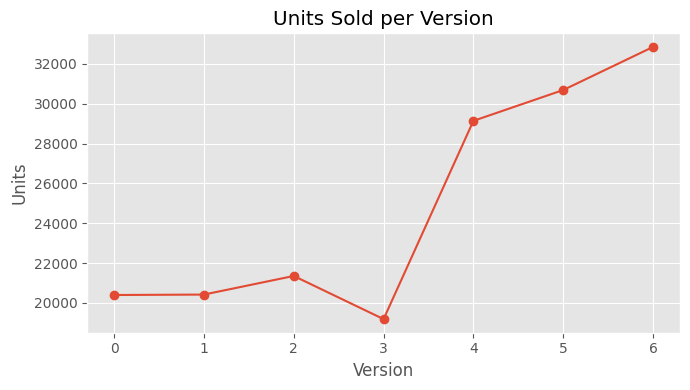

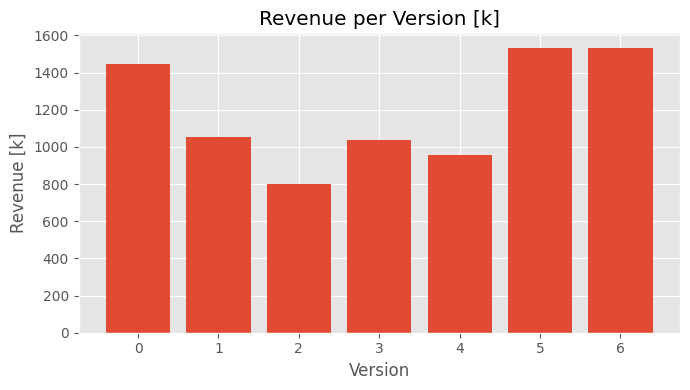

In [4]:
# === Quick sanity plots (volume & revenue) ===================================
sumv = df_ind.groupby("version")[["qty","revenue"]].sum().reset_index()
plt.figure(figsize=(7,4)); plt.plot(sumv["version"], sumv["qty"], marker="o"); 
plt.title("Units Sold per Version"); plt.xlabel("Version"); plt.ylabel("Units"); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,4)); plt.bar(sumv["version"], sumv["revenue"]/1000); 
plt.title("Revenue per Version [k]"); plt.xlabel("Version"); plt.ylabel("Revenue [k]"); plt.tight_layout(); plt.show()